<a href="https://colab.research.google.com/github/yubai00/Joint-Lab-1/blob/main/Joint_Lab_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Yu Bai, Yutian Chen, Tianxiao Wei

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
delta_t = 1
pi = np.pi

def pwm2rot(pwm):
        # maps from PWM to rotational speed
        return pwm * 100

In [ ]:
class envir:
    # the environment is a rectangular consisting 4 walls bounding an open space
    # the positions of the walls are x=0, y=0, x=length, y=width
    def __init__(self, length, width):
        self.length = length
        self.width = width

In [ ]:
class robot:

    def __init__(self, envir, width, diameter, x0 = 0, y0 = 0, theta0 = 0, ifOutput = True, ifPlot = True):
        self.envir = envir
        self.width = width
        self.diameter = diameter
        self.x = x0
        self.y = y0
        self.theta = theta0
        self.front_dist = 0
        self.right_dist = 0
        self.rot_speed = 0
        self.ns_mag_field = 0
        self.ew_mag_field = 0
        self.update_sensor()
        self.measure()
        if ifOutput:
            self.output()
        if ifPlot:
            self.plot()

    def move(self, pwm_l, pwm_r, ifOutput = True, ifPlot = True):
        width = self.width
        theta = self.theta
        # map from PWM to rotation speed
        rot_l = pwm2rot(pwm_l)
        rot_r = pwm2rot(pwm_r)

        # B is the matrix in x(t+1) = A*x(t) + B*u(t)
        B = delta_t * self.diameter/2 * np.array([[1/2 * np.cos(theta), 1/2 * np.cos(theta)],[1/2 * np.sin(theta), 1/2 * np.sin(theta)], [-1/width, 1/width]])
        # input is the input vector u(t)
        input = np.array([[rot_l],[rot_r]])

        # if the potential destination is out of the envrionment (blocked by a wall), it will not move
        [[pot_x], [pot_y], [pot_theta]] = [[self.x], [self.y], [self.theta]] + B.dot(input)
        if pot_x < 0 or pot_x > self.envir.length or pot_y < 0 or pot_y > self.envir.width:
            print("The robot didn't move because it is out of bound")
            if ifOutput:
                self.output()
            if ifPlot:
                self.plot()
            return

        # updates the system state with x(t+1) = A*x(t) + B*u(t)
        [self.x, self.y, self.theta] = [pot_x, pot_y, pot_theta]

        # reduce theta to be in the range of [0,2*pi)
        self.theta = np.remainder(self.theta, 2*pi)

        self.update_sensor() # update the sensors
        # updates the rotational speed
        self.rot_speed = self.diameter/(2 * width) * (rot_r - rot_l)
        self.measure() # provide sensor outputs
        if ifOutput:
            self.output()
        if ifPlot:
            self.plot()

    def update_sensor(self):
        # update the equations for the sensor lasers
        # y = mf*x + bf describes the laser from the front sensor
        # note that np.tan() will never be undefined due to the limitations of computer calculation,
        # thus we will have always have the function y = mf*x + bf for all states
        self.mf = np.tan(self.theta)
        self.bf = self.y - self.mf * self.x
        # y = mr*x + br describes the laser from the right sensor
        self.mr = np.tan(self.theta - pi/2)
        self.br = self.y - self.mr * self.x

    def measure(self):
        # in simulation, instead of directly obtaining outputs from the sensors, we calculate the sensor outputs with current state, input, and noise
        # calculate the intersection and distance between the front laser and the rectangular walls
        # if we know the x-coordinate of the wall, y = mx + b
        # if we know the y-coordinate of the wall, x = (y-b)/m
        l = self.envir.length
        w = self.envir.width
        mf = self.mf
        bf = self.bf
        mr = self.mr
        br = self.br

        # front_inter[0] to front_inter[4] are the intersections with the walls on the right, top, left, buttom, right
        # front_inter[4] is used to simply future calculations
        front_inter = np.zeros((5,2))
        if l*mf+bf >=0 and l*mf+bf <= w:
            front_inter[0] = [l, l*mf+bf]
            front_inter[4] = [l, l*mf+bf]
        if (w-bf)/mf >= 0 and (w-bf)/mf <= l: 
            front_inter[1] = [(w-bf)/mf, w]
        if bf >=0 and bf <= w:
            front_inter[2] = [0, bf]
        if -bf/mf >= 0 and -bf/mf <= l:
            front_inter[3] = [-bf/mf, 0]

        # if 0 <= theta < pi/2, we only need to consider the intersection with the right or top wall
        # if pi/2 <= theta < pi, we only need to consider the intersection with the top or left wall
        # if pi <= theta < 3pi/2, we only need to consider the intersection with the left or buttom wall
        # if 3pi/2 <= theta < 2pi, we only need to consider the intersection with the buttom or right wall
        # therefore, we use np.floor(theta/(pi/2)) to determine which walls need to be considered
        # since the laser y=mx+b will only intersect with one of the two adajacent walls, and the coordinate is set to [0,0] if there is no intersection,
        # we can directly compute the intersection by adding the values of adjacent rows in front_inter
        idx = int(np.floor(self.theta/(pi/2)))
        front_inter_loc = front_inter[idx] + front_inter[idx+1]
        self.front_dist = np.sqrt(np.power(self.x-front_inter_loc[0],2) + np.power(self.y-front_inter_loc[1],2))

        # right_inter[0] to right_inter[4] are the intersections with the walls on the buttom, right, top, left, buttom
        # right_inter[4] is used to simply future calculations  
        right_inter = np.zeros((5,2))
        if -br/mr >= 0 and -br/mr <= l:
            right_inter[0] = [-br/mr, 0]
            right_inter[4] = [-br/mr, 0]
        if l*mr+br >=0 and l*mr+br <= w:
            front_inter[1] = [l, l*mr+br]
        if (w-br)/mr >= 0 and (w-br)/mr <= l: 
            front_inter[2] = [(w-br)/mr, w]
        if br >=0 and br <= w:
            front_inter[3] = [0, br]

        # similar to the calculation of the front intersection
        idx = int(np.floor(self.theta/(pi/2)))
        right_inter_loc = right_inter[idx] + right_inter[idx+1]
        self.right_dist = np.sqrt(np.power(self.x-right_inter_loc[0],2) + np.power(self.y-right_inter_loc[1],2))


        # calculate the north-south and east-west magnetic field
        self.ns_mag_field = np.sin(self.theta)
        self.ew_mag_field = np.cos(self.theta)


    def output(self):
        print("x, y, theta                = ", ', '.join(str(i) for i in [self.x, self.y, self.theta]))
        print("front distance             = ", self.front_dist)
        print("right distance             = ", self.right_dist)
        print("rotational speed           = ", self.rot_speed)
        print("north-south magnetic field = ", self.ns_mag_field)
        print("east-west magnetic field   = ", self.ew_mag_field)

    def plot(self):
        plt.figure(figsize = (10,10))
        # plot the rectangular environment
        plt.vlines(x=[0, self.envir.length], ymin=0, ymax=self.envir.width)
        plt.hlines(y=[0, self.envir.width], xmin=0, xmax=self.envir.length)
        # plot the position of the robot
        plt.plot(self.x, self.y, 'ro')
        # plot the front and right sensor
        plt.quiver([self.x, self.x], [self.y, self.y],[np.cos(self.theta), np.sin(self.theta)], [np.cos(self.theta-pi/2), np.sin(self.theta-pi/2)], 
                   angles='xy', scale_units='xy', scale=1)
        plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


x, y, theta                =  0, 0, 0
front distance             =  10.0
right distance             =  0.0
rotational speed           =  0
north-south magnetic field =  0.0
east-west magnetic field   =  1.0


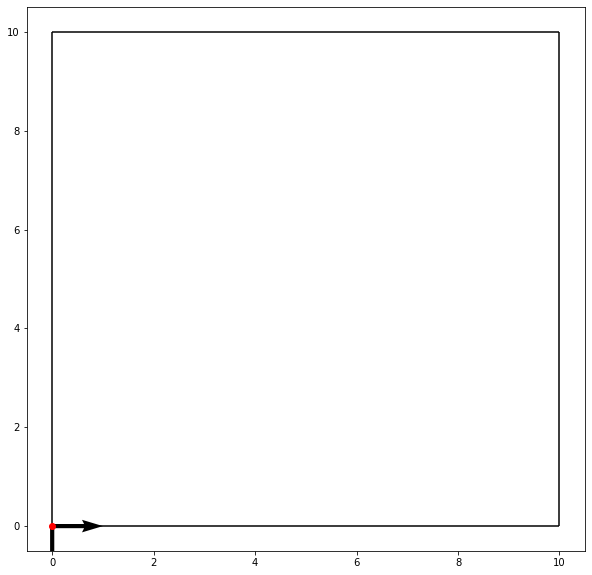

In [ ]:
e = envir(10,10)
r = robot(e,1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


x, y, theta                =  1.0, 0.0, 0.0
front distance             =  9.0
right distance             =  0.0
rotational speed           =  0.0
north-south magnetic field =  0.0
east-west magnetic field   =  1.0


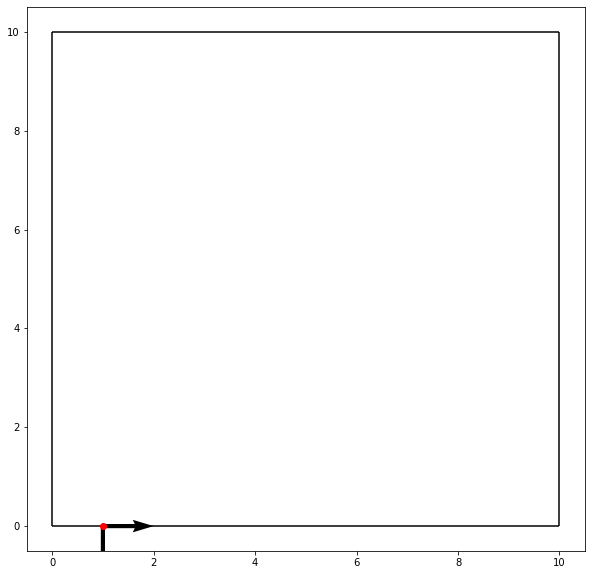

In [ ]:
r.move(0.01, 0.01)